In [ ]:
# Installing required packages
!pip install pandas numpy textblob python-dateutil matplotlib

In [ ]:
# Importing necessary libraries
import os
import ast
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
# Setting ESG data file name
esg_file = "076372d9-8f5a-4fa7-bc1c-cd0471f3659e_Data.csv"

In [ ]:
# loading ESG dataset
esg_raw = pd.read_csv(esg_file)

In [ ]:
# printing basic info
print("ESG raw shape:", esg_raw.shape)
print("ESG columns:", esg_raw.columns[:10])

ESG raw shape: (16974, 68)
ESG columns: Index(['Country Name', 'Country Code', 'Series Name', 'Series Code',
       '1960 [YR1960]', '1961 [YR1961]', '1962 [YR1962]', '1963 [YR1963]',
       '1964 [YR1964]', '1965 [YR1965]'],
      dtype='object')


In [ ]:
# Filtering for USA only
esg_usa = esg_raw[esg_raw["Country Code"] == "USA"].copy()
print("ESG USA shape:", esg_usa.shape)

ESG USA shape: (71, 68)


In [ ]:
# Selecting year columns
year_cols = [c for c in esg_usa.columns if "[YR" in c]

In [ ]:
# Selecting id columns
id_cols = ["Country Name", "Country Code", "Series Name", "Series Code"]

In [ ]:
# Reshaping from wide to long
esg_long = esg_usa.melt(
    id_vars=id_cols,
    value_vars=year_cols,
    var_name="YearStr",
    value_name="Value")

In [ ]:
# Extracting numeric year
esg_long["Year"] = esg_long["YearStr"].str.extract(r"(\d{4})").astype(int)

In [ ]:
# Converting Value to numeric
esg_long["Value"] = pd.to_numeric(esg_long["Value"], errors="coerce")

In [ ]:
# Filtering for years 2020–2024
esg_long = esg_long[(esg_long["Year"] >= 2020) & (esg_long["Year"] <= 2024)]

In [ ]:
# Dropping missing values
esg_long = esg_long.dropna(subset=["Value"])

In [ ]:
# Printing the ESG data shape
print("ESG long (USA, 2020–2024) shape:", esg_long.shape)

ESG long (USA, 2020–2024) shape: (176, 7)


In [ ]:
# Printing the head of the data
esg_long.head()

,Country Name,Country Code,Series Name,Series Code,YearStr,Value,Year
4260,United States,USA,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,2020 [YR2020],100.000000,2020
4261,United States,USA,Access to electricity (% of population),EG.ELC.ACCS.ZS,2020 [YR2020],100.000000,2020
4262,United States,USA,Adjusted savings: natural resources depletion ...,NY.ADJ.DRES.GN.ZS,2020 [YR2020],0.160767,2020
4263,United States,USA,Adjusted savings: net forest depletion (% of GNI),NY.ADJ.DFOR.GN.ZS,2020 [YR2020],0.000000,2020
4264,United States,USA,Agricultural land (% of land area),AG.LND.AGRI.ZS,2020 [YR2020],45.334279,2020


In [ ]:
# Listing some ESG series codes
selected_series = [
    "EG.CFT.ACCS.ZS",    # Access to clean fuels and technologies for cooking
    "EG.ELC.ACCS.ZS",    # Access to electricity
    "NY.ADJ.DRES.GN.ZS", # Adjusted savings: natural resources depletion
    "NY.ADJ.DFOR.GN.ZS", # Adjusted savings: net forest depletion
    "AG.LND.AGRI.ZS"]     # Agricultural land

In [ ]:
# Filtering for selected series
esg_filtered = esg_long[esg_long["Series Code"].isin(selected_series)].copy()

In [ ]:
# Printing the ESG filtered shape
print("ESG filtered shape:", esg_filtered.shape)

ESG filtered shape: (14, 7)


In [ ]:
# Printing the unique series codes
print("Unique series codes kept:", esg_filtered["Series Code"].unique())

Unique series codes kept: ['EG.CFT.ACCS.ZS' 'EG.ELC.ACCS.ZS' 'NY.ADJ.DRES.GN.ZS' 'NY.ADJ.DFOR.GN.ZS'
 'AG.LND.AGRI.ZS']


In [ ]:
# Pivoting so each row = Year, each column = Series Code
esg_pivot = esg_filtered.pivot_table(
    index="Year",
    columns="Series Code",
    values="Value",
    aggfunc="mean"
).reset_index()

In [ ]:
# flattening columns
esg_pivot.columns.name = None

In [ ]:
# renaming columns to cleaner names
rename_map = {
    "EG.CFT.ACCS.ZS": "Access_Clean_Fuels_pct",
    "EG.ELC.ACCS.ZS": "Access_Electricity_pct",
    "NY.ADJ.DRES.GN.ZS": "Nat_Resource_Depletion_pctGNI",
    "NY.ADJ.DFOR.GN.ZS": "Forest_Depletion_pctGNI",
    "AG.LND.AGRI.ZS": "Agricultural_Land_pct"
}
esg_pivot = esg_pivot.rename(columns=rename_map)

In [ ]:
# Printing updated by Year shape
print("ESG pivoted (by Year) shape:", esg_pivot.shape)

ESG pivoted (by Year) shape: (4, 6)


In [ ]:
# Printing the pivot table
display(esg_pivot)

,Year,Agricultural_Land_pct,Access_Clean_Fuels_pct,Access_Electricity_pct,Forest_Depletion_pctGNI,Nat_Resource_Depletion_pctGNI
0,2020,45.334279,100.0,100.0,0.0,0.160767
1,2021,45.209715,100.0,100.0,0.0,0.815193
2,2022,45.085151,100.0,100.0,NaN,NaN
3,2023,NaN,NaN,100.0,NaN,NaN


In [ ]:
# Loading all S&P 500 data
spx_files = [
    "INDEX_US_S&P US_SPX2020.csv",
    "INDEX_US_S&P US_SPX2021.csv",
    "INDEX_US_S&P US_SPX2022.csv",
    "INDEX_US_S&P US_SPX2023.csv",
    "INDEX_US_S&P US_SPX2024.csv"]

In [ ]:
# Loading all S&P data files
spx_dfs = []
for f in spx_files:
    if not os.path.exists(f):
        raise FileNotFoundError(f"Missing S&P file: {f}")

    # loading S&P data
    df = pd.read_csv(f)

    # cleaning column names
    df.columns = [c.strip() for c in df.columns]

    # parsing date
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df = df.dropna(subset=["Date"])

    # converting OHLC to numeric
    for col in ["Open", "High", "Low", "Close"]:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(",", ""), errors="coerce")

    spx_dfs.append(df)

In [ ]:
# Concatenating all years
spx_all = pd.concat(spx_dfs, ignore_index=True)

In [ ]:
# dropping duplicates by date
spx_all = spx_all.drop_duplicates(subset=["Date"]).sort_values("Date").reset_index(drop=True)

In [ ]:
# adding daily return
spx_all["Return"] = spx_all["Close"].pct_change()

In [ ]:
# extracting year
spx_all["Year"] = spx_all["Date"].dt.year

In [ ]:
# Printing the S&P combined shape
print("S&P combined shape:", spx_all.shape)

S&P combined shape: (1258, 7)


In [ ]:
# Printing the S&P combined head
print(spx_all.head())

        Date     Open     High      Low    Close    Return  Year
0 2020-01-02  3244.67  3258.14  3235.53  3257.85       NaN  2020
1 2020-01-03  3226.36  3246.15  3222.34  3234.85 -0.007060  2020
2 2020-01-06  3217.55  3246.84  3214.64  3246.28  0.003533  2020
3 2020-01-07  3241.86  3244.91  3232.43  3237.18 -0.002803  2020
4 2020-01-08  3238.59  3267.07  3236.67  3253.05  0.004902  2020


In [ ]:
# grouping and aggregating
spx_yearly = spx_all.groupby("Year").agg({
    "Return": ["mean", "std"],
    "Close": ["first", "last"]})

In [ ]:
# flattening multiindex columns
spx_yearly.columns = ["Return_mean", "Return_std", "Close_open_year", "Close_end_year"]
spx_yearly = spx_yearly.reset_index()

In [ ]:
# computing annual return
spx_yearly["Annual_Return"] = (spx_yearly["Close_end_year"] / spx_yearly["Close_open_year"]) - 1

In [ ]:
# Printing S&P yearly aggregated
print(spx_yearly)

   Year  Return_mean  Return_std  Close_open_year  Close_end_year  \
0  2020     0.000802    0.021728          3257.85         3756.07   
1  2021     0.000980    0.008251          3700.65         4766.18   
2  2022    -0.000745    0.015228          4796.56         3839.50   
3  2023     0.000902    0.008248          3824.14         4769.83   
4  2024     0.000863    0.007969          4742.83         5881.63   

   Annual_Return  
0       0.152929  
1       0.287930  
2      -0.199530  
3       0.247295  
4       0.240110  


In [ ]:
# merging on Year
merged_yearly = spx_yearly.merge(esg_pivot, on="Year", how="left")

In [ ]:
# Printing Merged yearly ESG shape
merged_yearly.shape

(5, 11)

In [ ]:
# Printing Merged yearly ESG
print(merged_yearly)

   Year  Return_mean  Return_std  Close_open_year  Close_end_year  \
0  2020     0.000802    0.021728          3257.85         3756.07   
1  2021     0.000980    0.008251          3700.65         4766.18   
2  2022    -0.000745    0.015228          4796.56         3839.50   
3  2023     0.000902    0.008248          3824.14         4769.83   
4  2024     0.000863    0.007969          4742.83         5881.63   

   Annual_Return  Agricultural_Land_pct  Access_Clean_Fuels_pct  \
0       0.152929              45.334279                   100.0   
1       0.287930              45.209715                   100.0   
2      -0.199530              45.085151                   100.0   
3       0.247295                    NaN                     NaN   
4       0.240110                    NaN                     NaN   

   Access_Electricity_pct  Forest_Depletion_pctGNI  \
0                   100.0                      0.0   
1                   100.0                      0.0   
2                   

In [ ]:
# merging ESG onto daily S&P by year
spx_with_esg_daily = spx_all.merge(esg_pivot, on="Year", how="left")

In [ ]:
# Displaying the first few rows of the data
display(spx_with_esg_daily.head())

,Date,Open,High,Low,Close,Return,Year,Agricultural_Land_pct,Access_Clean_Fuels_pct,Access_Electricity_pct,Forest_Depletion_pctGNI,Nat_Resource_Depletion_pctGNI
0,2020-01-02,3244.67,3258.14,3235.53,3257.85,NaN,2020,45.334279,100.0,100.0,0.0,0.160767
1,2020-01-03,3226.36,3246.15,3222.34,3234.85,-0.007060,2020,45.334279,100.0,100.0,0.0,0.160767
2,2020-01-06,3217.55,3246.84,3214.64,3246.28,0.003533,2020,45.334279,100.0,100.0,0.0,0.160767
3,2020-01-07,3241.86,3244.91,3232.43,3237.18,-0.002803,2020,45.334279,100.0,100.0,0.0,0.160767
4,2020-01-08,3238.59,3267.07,3236.67,3253.05,0.004902,2020,45.334279,100.0,100.0,0.0,0.160767


In [ ]:
# Printing the total Rows and columns of the dataset
print("Total Rows:", spx_with_esg_daily.shape[0])
print("Total Columns:", spx_with_esg_daily.shape[1])

Total Rows: 1258
Total Columns: 12


In [ ]:
# Printing the information of the dataset
spx_with_esg_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Date                           1258 non-null   datetime64[ns]
 1   Open                           1258 non-null   float64       
 2   High                           1258 non-null   float64       
 3   Low                            1258 non-null   float64       
 4   Close                          1258 non-null   float64       
 5   Return                         1257 non-null   float64       
 6   Year                           1258 non-null   int32         
 7   Agricultural_Land_pct          756 non-null    float64       
 8   Access_Clean_Fuels_pct         756 non-null    float64       
 9   Access_Electricity_pct         1006 non-null   float64       
 10  Forest_Depletion_pctGNI        505 non-null    float64       
 11  Nat_Resource_Depl

In [ ]:
# Checking for the missing values in the dataset
print(spx_with_esg_daily.isnull().sum())

Date                               0
Open                               0
High                               0
Low                                0
Close                              0
Return                             1
Year                               0
Agricultural_Land_pct            502
Access_Clean_Fuels_pct           502
Access_Electricity_pct           252
Forest_Depletion_pctGNI          753
Nat_Resource_Depletion_pctGNI    753
dtype: int64


In [ ]:
# identifying ESG columns for imputing
esg_cols = [
    'Agricultural_Land_pct',
    'Access_Clean_Fuels_pct',
    'Access_Electricity_pct',
    'Forest_Depletion_pctGNI',
    'Nat_Resource_Depletion_pctGNI']

In [ ]:
# Imputing ESG features by filling with yearly mean values
for col in esg_cols:
    # computing yearly mean for each ESG column
    yearly_mean = spx_with_esg_daily.groupby('Year')[col].transform('mean')
    # filling missing values with yearly mean
    spx_with_esg_daily[col] = spx_with_esg_daily[col].fillna(yearly_mean)

In [ ]:
# if any NaNs still remain then, using global mean as fallback
for col in esg_cols:
    spx_with_esg_daily[col] = spx_with_esg_daily[col].fillna(spx_with_esg_daily[col].mean())

In [ ]:
# printing missing values after imputing
print(spx_with_esg_daily[esg_cols].isnull().sum())

Agricultural_Land_pct            0
Access_Clean_Fuels_pct           0
Access_Electricity_pct           0
Forest_Depletion_pctGNI          0
Nat_Resource_Depletion_pctGNI    0
dtype: int64


In [ ]:
# Printing the summary statistics of the dataset
print(spx_with_esg_daily.describe())

                                Date         Open         High          Low  \
count                           1258  1258.000000  1258.000000  1258.000000   
mean   2022-07-01 15:39:46.645468928  4258.916145  4283.980700  4232.242695   
min              2020-01-02 00:00:00  2290.710000  2300.730000  2191.860000   
25%              2021-04-02 00:00:00  3817.265000  3846.012500  3791.585000   
50%              2022-06-30 12:00:00  4206.095000  4233.785000  4186.005000   
75%              2023-10-01 06:00:00  4602.850000  4631.122500  4579.505000   
max              2024-12-31 00:00:00  6089.030000  6099.970000  6079.980000   
std                              NaN   767.478563   765.438424   769.613239   

             Close       Return         Year  Agricultural_Land_pct  \
count  1258.000000  1257.000000  1258.000000            1258.000000   
mean   4259.611264     0.000561  2021.996820              45.210045   
min    2237.400000    -0.119841  2020.000000              45.085151   
25% 

In [ ]:
# Printing the unique values
print(spx_with_esg_daily.nunique())

Date                             1258
Open                             1254
High                             1252
Low                              1254
Close                            1257
Return                           1257
Year                                5
Agricultural_Land_pct               4
Access_Clean_Fuels_pct              1
Access_Electricity_pct              1
Forest_Depletion_pctGNI             1
Nat_Resource_Depletion_pctGNI       3
dtype: int64


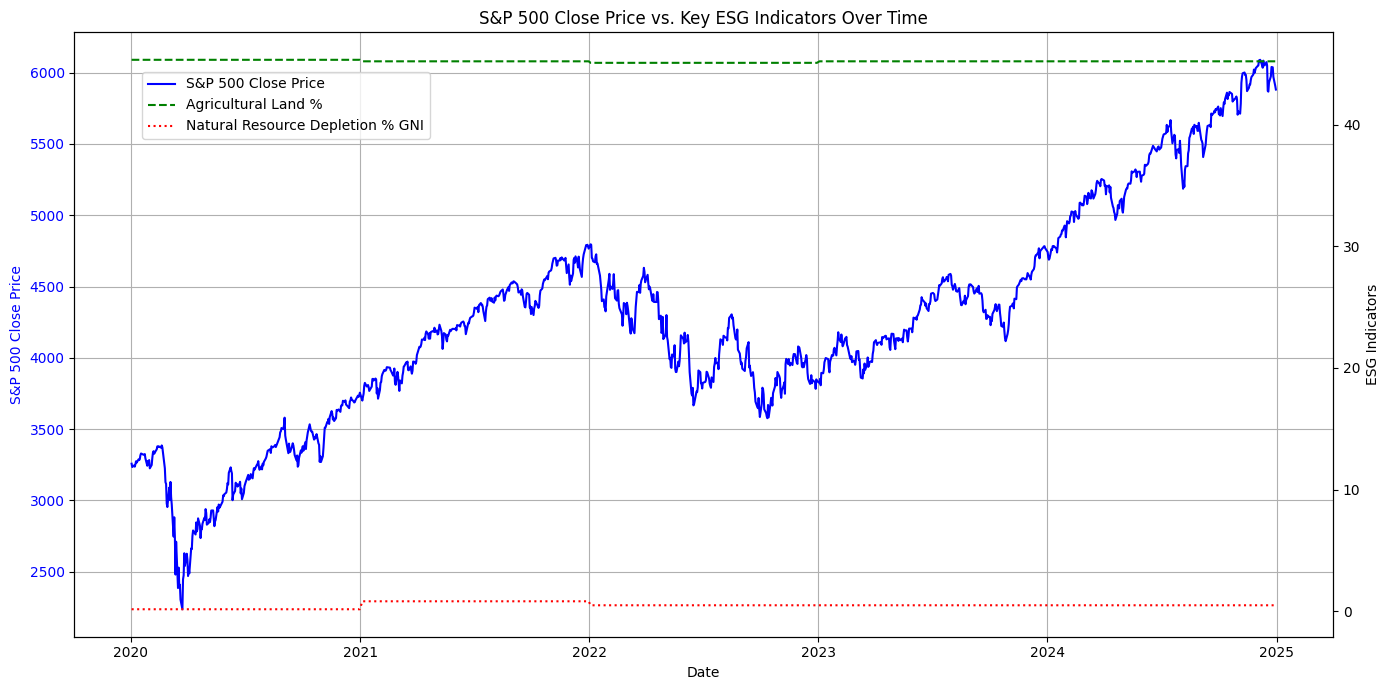

In [ ]:
# Creating a combined time series plot with the S&P 500 Close price
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plotting S&P 500 Close Price on primary y-axis
ax1.plot(spx_with_esg_daily['Date'], spx_with_esg_daily['Close'], color='blue', label='S&P 500 Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('S&P 500 Close Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

# Creating a secondary y-axis for ESG indicators
ax2 = ax1.twinx()

# Plotting ESG indicators on secondary y-axis
ax2.plot(spx_with_esg_daily['Date'], spx_with_esg_daily['Agricultural_Land_pct'], color='green', linestyle='--', label='Agricultural Land %')
ax2.plot(spx_with_esg_daily['Date'], spx_with_esg_daily['Nat_Resource_Depletion_pctGNI'], color='red', linestyle=':', label='Natural Resource Depletion % GNI')
ax2.set_ylabel('ESG Indicators', color='black')
ax2.tick_params(axis='y')

# Adding title and legend
plt.title('S&P 500 Close Price vs. Key ESG Indicators Over Time')
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
plt.tight_layout()
plt.show()

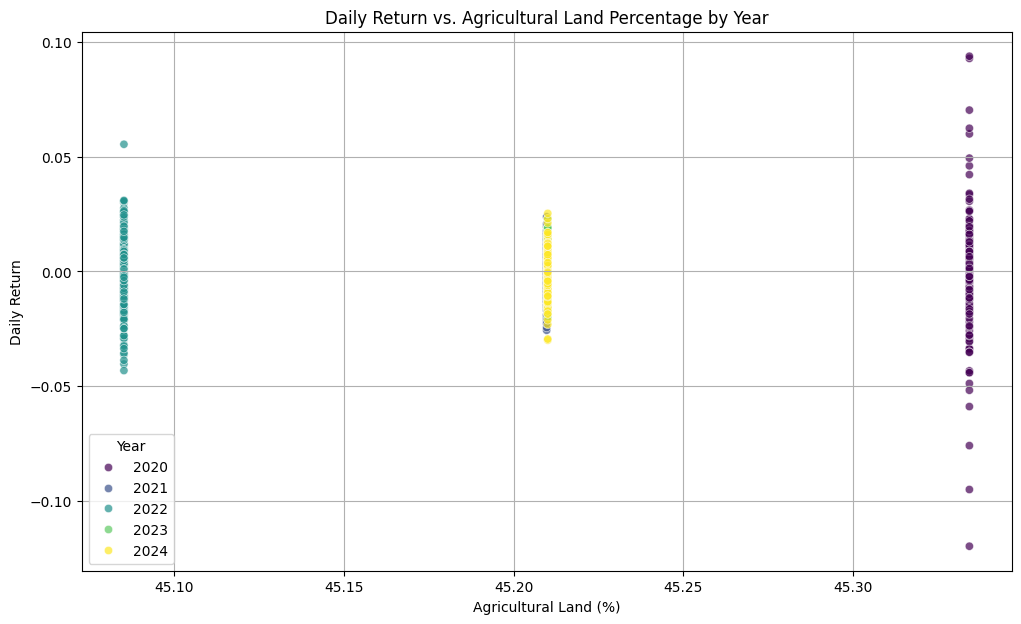

In [ ]:
# Creating a scatter plot of Daily Return vs. Agricultural Land Percentage by Year
plt.figure(figsize=(12, 7))
sns.scatterplot(data=spx_with_esg_daily, x='Agricultural_Land_pct', y='Return', hue='Year', palette='viridis', alpha=0.7)
plt.title('Daily Return vs. Agricultural Land Percentage by Year')
plt.xlabel('Agricultural Land (%)')
plt.ylabel('Daily Return')
plt.grid(True)
plt.legend(title='Year')
plt.show()

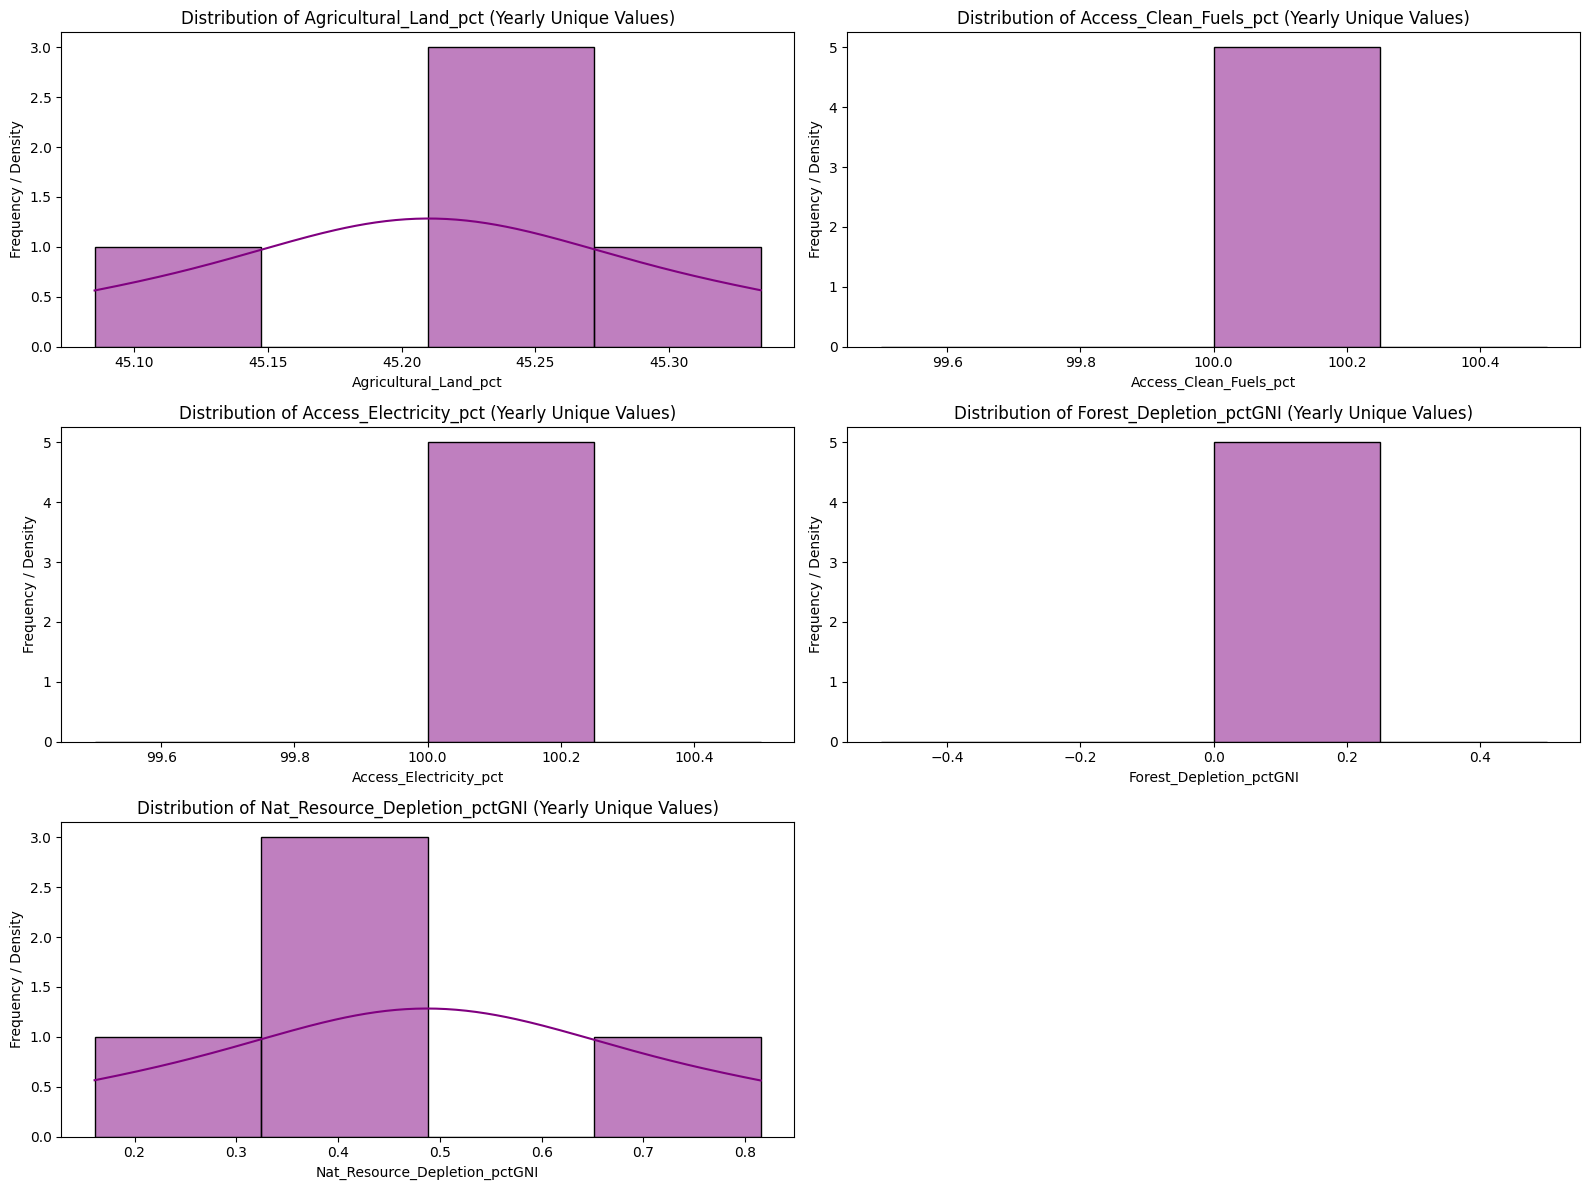

In [ ]:
# Plotting histograms for the distributions of unique yearly values
esg_hist_cols = [
    'Agricultural_Land_pct',
    'Access_Clean_Fuels_pct',
    'Access_Electricity_pct',
    'Forest_Depletion_pctGNI',
    'Nat_Resource_Depletion_pctGNI']
plt.figure(figsize=(16, 12))
for i, col in enumerate(esg_hist_cols):
    plt.subplot(3, 2, i + 1)
    # Extract unique yearly values for each ESG indicator
    unique_yearly_values = spx_with_esg_daily.groupby('Year')[col].first().dropna()
    sns.histplot(unique_yearly_values, kde=True, bins=max(1, len(unique_yearly_values) - 1), color='purple')
    plt.title(f'Distribution of {col} (Yearly Unique Values)')
    plt.xlabel(col)
    plt.ylabel('Frequency / Density')
plt.tight_layout()
plt.show()

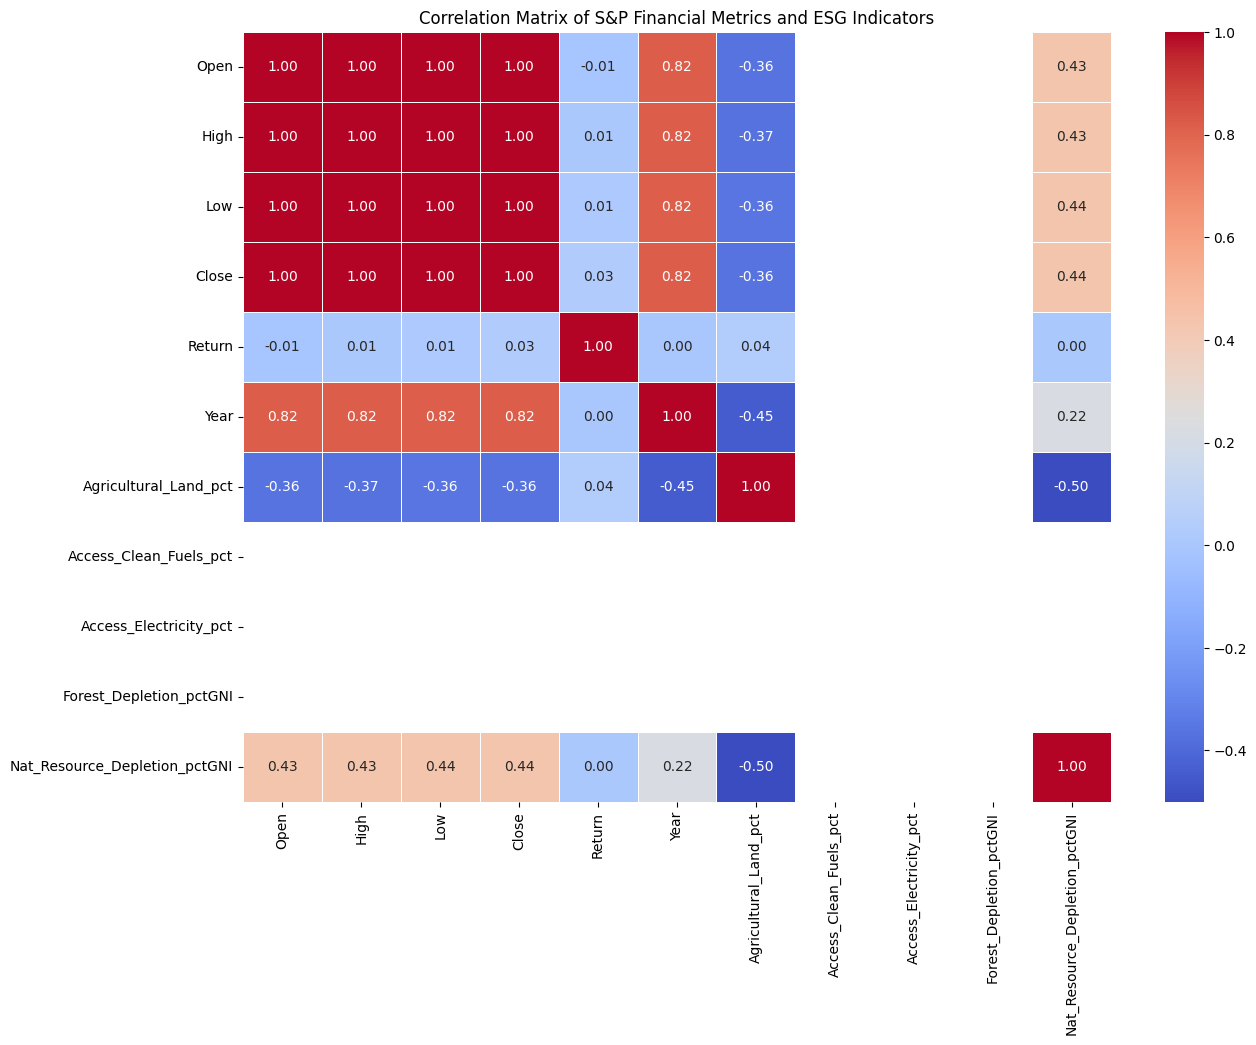

In [ ]:
# Correlation heatmap of S&P financial metrics
financial_metrics = ['Open', 'High', 'Low', 'Close', 'Return', 'Year']
esg_indicators = ['Agricultural_Land_pct', 'Access_Clean_Fuels_pct', 'Access_Electricity_pct', 'Forest_Depletion_pctGNI', 'Nat_Resource_Depletion_pctGNI']

# Combining all columns
all_cols = financial_metrics + esg_indicators

# Plotting the heatmap of correlation matrix
correlation_matrix = spx_with_esg_daily[all_cols].corr()
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of S&P Financial Metrics and ESG Indicators')
plt.show()

In [ ]:
# creating lagged return features
spx_with_esg_daily["Return_lag1"] = spx_with_esg_daily["Return"].shift(1)
spx_with_esg_daily["Return_lag5"] = spx_with_esg_daily["Return"].shift(5)
spx_with_esg_daily["Return_lag10"] = spx_with_esg_daily["Return"].shift(10)

In [ ]:
# creating rolling statistics
spx_with_esg_daily["Rolling_Mean_5"] = spx_with_esg_daily["Return"].rolling(window=5).mean()
spx_with_esg_daily["Rolling_Std_5"] = spx_with_esg_daily["Return"].rolling(window=5).std()

In [ ]:
# creating target
spx_with_esg_daily["Return_t_plus_1"] = spx_with_esg_daily["Return"].shift(-1)
spx_with_esg_daily["Direction_t_plus_1"] = (spx_with_esg_daily["Return_t_plus_1"] > 0).astype(int)

In [ ]:
# Dropping missing rows after shifting
spx_model = spx_with_esg_daily.dropna().copy()
print("Modelling shape:", spx_model.shape)

Modelling shape: (1246, 19)


In [ ]:
# defining feature set
feature_cols = [
    "Agricultural_Land_pct",
    "Access_Clean_Fuels_pct",
    "Access_Electricity_pct",
    "Forest_Depletion_pctGNI",
    "Nat_Resource_Depletion_pctGNI",
    "Return",
    "Return_lag1",
    "Return_lag5",
    "Return_lag10",
    "Rolling_Mean_5",
    "Rolling_Std_5"]

In [ ]:
# dropping rows with NaNs in features
spx_model = spx_model.dropna(subset=feature_cols)

In [ ]:
# creating X and y
X = spx_model[feature_cols]
y = spx_model["Direction_t_plus_1"]

In [ ]:
# splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False)

In [ ]:
# fitting the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced")
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [ ]:
# predicting on test set
rfy_pred = rf_model.predict(X_test)

In [ ]:
# evaluating accuracy
rfacc = accuracy_score(y_test, rfy_pred)*100
print("Random Forest Direction Accuracy:", rfacc)
print("\nClassification report:\n", classification_report(y_test, rfy_pred))

Random Forest Direction Accuracy: 50.0

Classification report:
               precision    recall  f1-score   support

           0       0.40      0.35      0.37       107
           1       0.56      0.62      0.58       143

    accuracy                           0.50       250
   macro avg       0.48      0.48      0.48       250
weighted avg       0.49      0.50      0.49       250



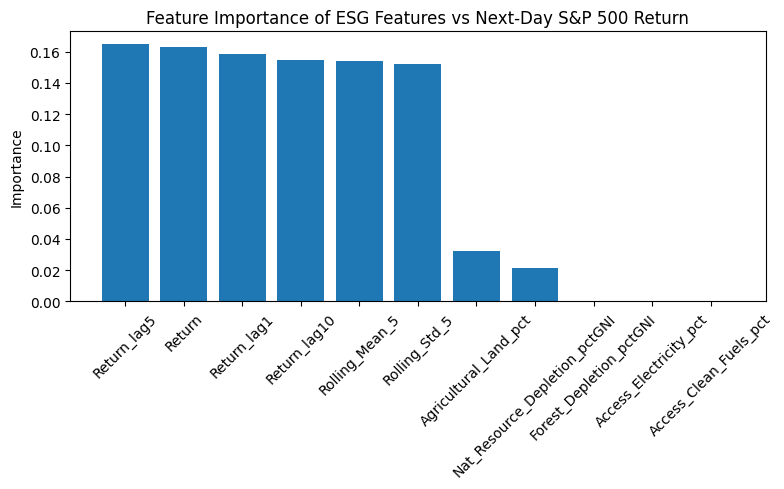

In [ ]:
# plotting feature importance for ESG variables
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(8, 5))
plt.bar(range(len(feature_cols)), importances[indices])
plt.xticks(range(len(feature_cols)), [feature_cols[i] for i in indices], rotation=45)
plt.ylabel("Importance")
plt.title("Feature Importance of ESG Features vs Next-Day S&P 500 Return")
plt.tight_layout()
plt.show()

In [ ]:
# initializing Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=42)

In [ ]:
# fitting the model
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.05, n_estimators=200,
                           random_state=42)

In [ ]:
# making predictions
gby_pred = gb_model.predict(X_test)

In [ ]:
# evaluation od gradient boosting model
gbacc = accuracy_score(y_test, gby_pred)
print("Gradient Boosting Accuracy:", gbacc)
print("\nClassification Report:\n", classification_report(y_test, gby_pred))

Gradient Boosting Accuracy: 0.548

Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.30      0.36       107
           1       0.58      0.73      0.65       143

    accuracy                           0.55       250
   macro avg       0.52      0.52      0.51       250
weighted avg       0.53      0.55      0.53       250



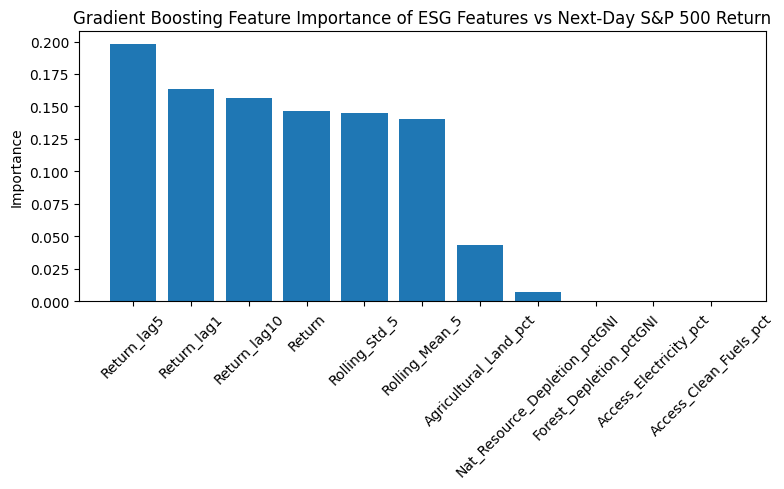

In [ ]:
# plotting feature importance for ESG variables
gbimportances = gb_model.feature_importances_
indices = np.argsort(gbimportances)[::-1]
plt.figure(figsize=(8, 5))
plt.bar(range(len(feature_cols)), gbimportances[indices])
plt.xticks(range(len(feature_cols)), [feature_cols[i] for i in indices], rotation=45)
plt.ylabel("Importance")
plt.title("Gradient Boosting Feature Importance of ESG Features vs Next-Day S&P 500 Return")
plt.tight_layout()
plt.show()

In [ ]:
# calculating naive baseline
baseline_accuracy = max(y_test.mean(), 1 - y_test.mean())
print(f"Baseline Accuracy: {baseline_accuracy*100:.2f}")
print(f"Gradient Boosting Accuracy: {gbacc*100:.2f}")

Baseline Accuracy: 57.20
Gradient Boosting Accuracy: 54.80


In [ ]:
# loading ESG metadata file (World Bank)
meta_file = "076372d9-8f5a-4fa7-bc1c-cd0471f3659e_Series - Metadata.csv"
if not os.path.exists(meta_file):
    print("Metadata file not found:", meta_file)
else:
    # reading metadata file
    meta = pd.read_csv(meta_file, encoding='latin1')

In [ ]:
# Printing shape and columns of Metadata
print("Shape:", meta.shape)
print("Columns:", meta.columns)

Shape: (17077, 68)
Columns: Index(['Country Name', 'Country Code', 'Series Name', 'Series Code',
       '1960 [YR1960]', '1961 [YR1961]', '1962 [YR1962]', '1963 [YR1963]',
       '1964 [YR1964]', '1965 [YR1965]', '1966 [YR1966]', '1967 [YR1967]',
       '1968 [YR1968]', '1969 [YR1969]', '1970 [YR1970]', '1971 [YR1971]',
       '1972 [YR1972]', '1973 [YR1973]', '1974 [YR1974]', '1975 [YR1975]',
       '1976 [YR1976]', '1977 [YR1977]', '1978 [YR1978]', '1979 [YR1979]',
       '1980 [YR1980]', '1981 [YR1981]', '1982 [YR1982]', '1983 [YR1983]',
       '1984 [YR1984]', '1985 [YR1985]', '1986 [YR1986]', '1987 [YR1987]',
       '1988 [YR1988]', '1989 [YR1989]', '1990 [YR1990]', '1991 [YR1991]',
       '1992 [YR1992]', '1993 [YR1993]', '1994 [YR1994]', '1995 [YR1995]',
       '1996 [YR1996]', '1997 [YR1997]', '1998 [YR1998]', '1999 [YR1999]',
       '2000 [YR2000]', '2001 [YR2001]', '2002 [YR2002]', '2003 [YR2003]',
       '2004 [YR2004]', '2005 [YR2005]', '2006 [YR2006]', '2007 [YR2007]',
   

In [ ]:
# filtering only ESG indicators
meta_subset = meta[meta["Series Code"].isin(selected_series)].copy()

In [ ]:
# reducing duplicates
meta_subset = meta_subset.drop_duplicates(subset=["Series Code"])

In [ ]:
# Printing Filtered metadata shape
meta_subset.shape

(5, 68)

In [ ]:
# Displaying the series code and name
display(meta_subset[["Series Code", "Series Name"]].head())

,Series Code,Series Name
0,EG.CFT.ACCS.ZS,Access to clean fuels and technologies for coo...
1,EG.ELC.ACCS.ZS,Access to electricity (% of population)
2,NY.ADJ.DRES.GN.ZS,Adjusted savings: natural resources depletion ...
3,NY.ADJ.DFOR.GN.ZS,Adjusted savings: net forest depletion (% of GNI)
4,AG.LND.AGRI.ZS,Agricultural land (% of land area)


In [ ]:
# Performing Vectorising ESG indicator names using CountVectorizer
vectorizer = CountVectorizer(
    stop_words="english",
    max_df=1.0,
    min_df=1)

In [ ]:
# fitting and transforming text
dtm = vectorizer.fit_transform(meta_subset["Series Name"])
print("Document-Term Matrix shape:", dtm.shape)

Document-Term Matrix shape: (5, 18)


In [ ]:
# choosing 2 topics
n_topics = 2
lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42)

In [ ]:
# Fitting LDA topic model
lda.fit(dtm)
feature_names = vectorizer.get_feature_names_out()

In [ ]:
# Defining a function to print the topics
def print_topics(model, feature_names, num_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic #{topic_idx + 1}:")
        top_features_idx = topic.argsort()[:-num_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_idx]
        print(", ".join(top_features))
print_topics(lda, feature_names, num_top_words=10)


Topic #1:
access, population, cooking, technologies, clean, fuels, electricity, land, area, agricultural

Topic #2:
savings, gni, depletion, adjusted, land, net, forest, resources, natural, agricultural


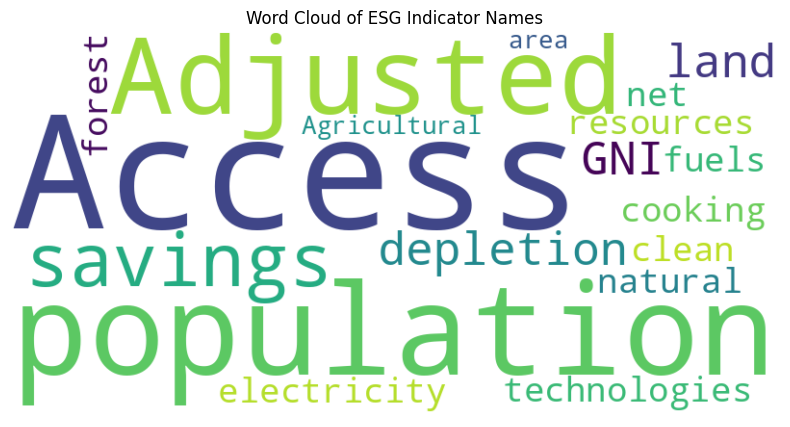

In [ ]:
# Generating Word Cloud from ESG indicator names
all_text = " ".join(meta_subset["Series Name"].tolist())
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white"
).generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of ESG Indicator Names")
plt.show()

In [ ]:
# Performing sentiment analysis on ESG indicator names
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity
meta_subset["Sentiment"] = meta_subset["Series Name"].apply(get_sentiment)

In [ ]:
# Printing Sentiment scores for ESG indicators
display(meta_subset[["Series Code", "Series Name", "Sentiment"]])

,Series Code,Series Name,Sentiment
0,EG.CFT.ACCS.ZS,Access to clean fuels and technologies for coo...,0.366667
1,EG.ELC.ACCS.ZS,Access to electricity (% of population),0.000000
2,NY.ADJ.DRES.GN.ZS,Adjusted savings: natural resources depletion ...,0.100000
3,NY.ADJ.DFOR.GN.ZS,Adjusted savings: net forest depletion (% of GNI),0.000000
4,AG.LND.AGRI.ZS,Agricultural land (% of land area),0.000000


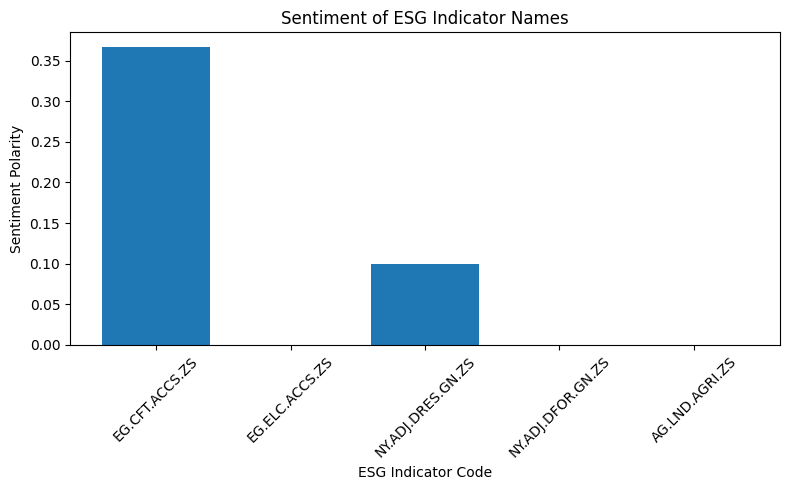

In [ ]:
# Plotting sentiment scores
plt.figure(figsize=(8, 5))
plt.bar(meta_subset["Series Code"], meta_subset["Sentiment"])
plt.xlabel("ESG Indicator Code")
plt.ylabel("Sentiment Polarity")
plt.title("Sentiment of ESG Indicator Names")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()